In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/facial-expression-dataset/test/test/surprise/PublicTest_78686873.jpg
/kaggle/input/facial-expression-dataset/test/test/surprise/PrivateTest_58522921.jpg
/kaggle/input/facial-expression-dataset/test/test/surprise/PrivateTest_83796714.jpg
/kaggle/input/facial-expression-dataset/test/test/surprise/PublicTest_84428313.jpg
/kaggle/input/facial-expression-dataset/test/test/surprise/PrivateTest_87978901.jpg
/kaggle/input/facial-expression-dataset/test/test/surprise/PrivateTest_90978621.jpg
/kaggle/input/facial-expression-dataset/test/test/surprise/PrivateTest_27580582.jpg
/kaggle/input/facial-expression-dataset/test/test/surprise/PublicTest_15760011.jpg
/kaggle/input/facial-expression-dataset/test/test/surprise/PublicTest_49739228.jpg
/kaggle/input/facial-expression-dataset/test/test/surprise/PublicTest_5351857.jpg
/kaggle/input/facial-expression-dataset/test/test/surprise/PrivateTest_56096676.jpg
/kaggle/input/facial-expression-dataset/test/test/surprise/PrivateTest_71692098.jp

In [3]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import load_img
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D

In [9]:
TRAIN_DIR = '../input/facial-expression-dataset/train/train/'
TEST_DIR = '../input/facial-expression-dataset/test/test/'


In [10]:
def load_dataset(directory):
    image_paths = []
    labels = []
    
    for label in os.listdir(directory):
        for filename in os.listdir(directory+label):
            image_path = os.path.join(directory, label, filename)
            image_paths.append(image_path)
            labels.append(label)
            
        print(label, "Completed")
    
    return image_paths, labels


In [11]:
## convert into dataframe
train = pd.DataFrame()
train['image'], train['label'] = load_dataset(TRAIN_DIR)
# shuffle the dataset
train = train.sample(frac=1).reset_index(drop=True)
train.head()


surprise Completed
fear Completed
angry Completed
neutral Completed
sad Completed
disgust Completed
happy Completed


,image,label
0,../input/facial-expression-dataset/train/train...,sad
1,../input/facial-expression-dataset/train/train...,sad
2,../input/facial-expression-dataset/train/train...,sad
3,../input/facial-expression-dataset/train/train...,neutral
4,../input/facial-expression-dataset/train/train...,surprise


In [12]:
test = pd.DataFrame()
test['image'], test['label'] = load_dataset(TEST_DIR)
test.head()

surprise Completed
fear Completed
angry Completed
neutral Completed
sad Completed
disgust Completed
happy Completed


,image,label
0,../input/facial-expression-dataset/test/test/s...,surprise
1,../input/facial-expression-dataset/test/test/s...,surprise
2,../input/facial-expression-dataset/test/test/s...,surprise
3,../input/facial-expression-dataset/test/test/s...,surprise
4,../input/facial-expression-dataset/test/test/s...,surprise


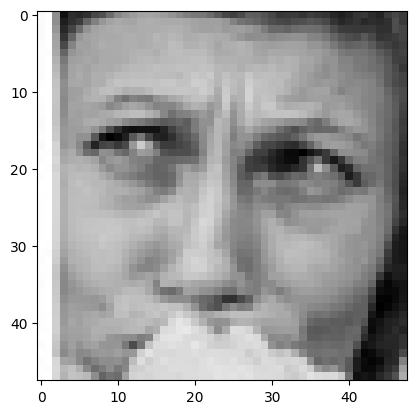

In [16]:
from PIL import Image
img = Image.open(train['image'][0])
plt.imshow(img, cmap='gray');


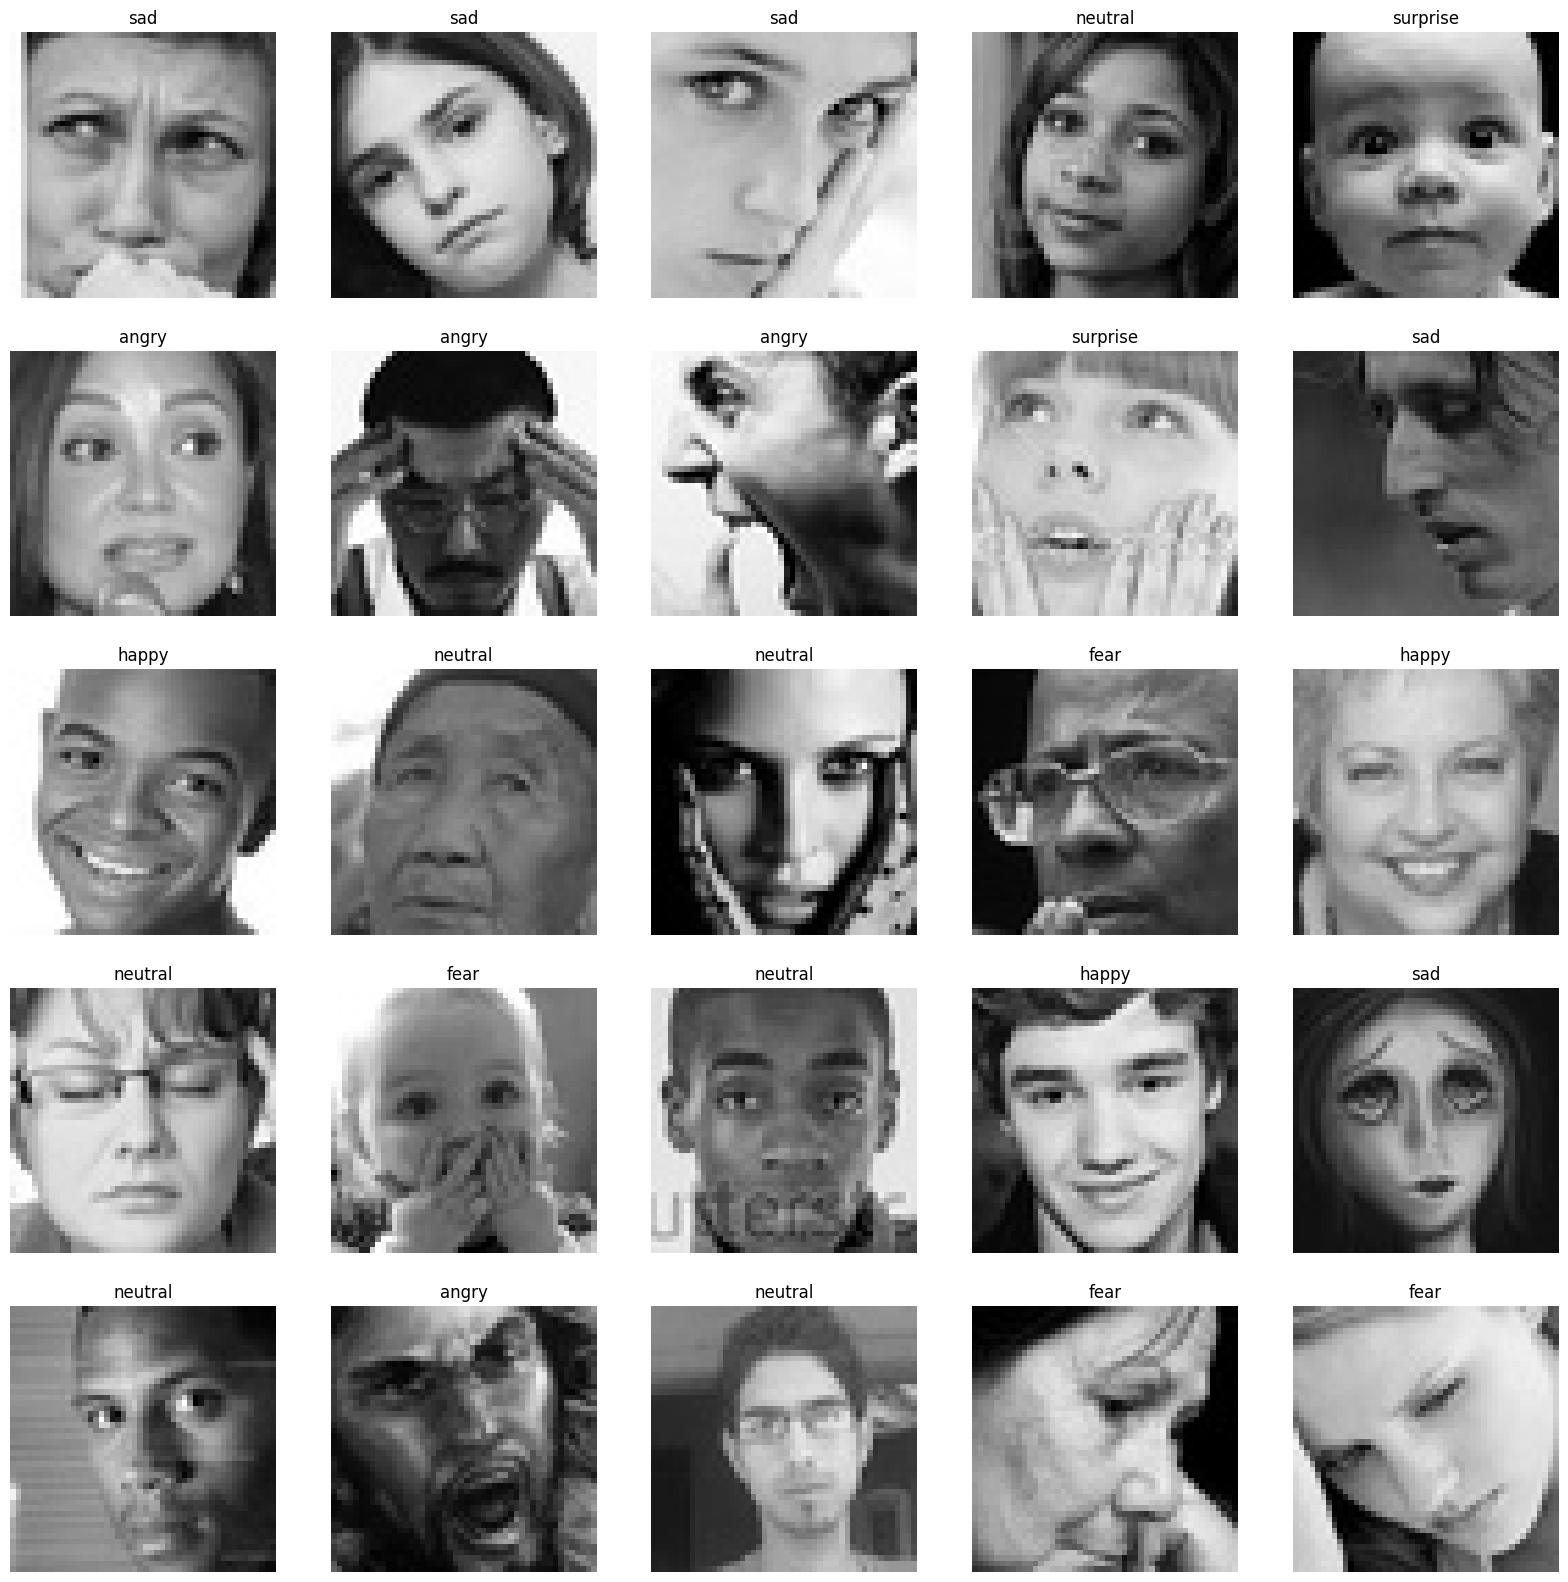

In [17]:
# to display grid of images
plt.figure(figsize=(20,20))
files = train.iloc[0:25]

for index, file, label in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')


In [20]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, color_mode='grayscale')  # ✅ fixed here
        img = np.array(img)
        features.append(img)
    return np.array(features)


In [23]:
train_features = extract_features(train['image'])


  0%|          | 0/28709 [00:00<?, ?it/s]

In [24]:
test_features = extract_features(test['image'])


  0%|          | 0/7178 [00:00<?, ?it/s]

In [25]:
## normalize the image
x_train = train_features/255.0
x_test = test_features/255.0

In [26]:
## convert label to integer
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train['label'])
y_train = le.transform(train['label'])
y_test = le.transform(test['label'])

In [27]:
y_train = to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7) 

In [28]:
y_train[0]

array([0., 0., 0., 0., 0., 1., 0.])

In [29]:
# config
input_shape = (48, 48, 1)
output_class = 7

In [31]:
model = Sequential()
# convolutional layers
model.add(Conv2D(128, kernel_size=(3,3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Flatten())
# fully connected layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
# output layer
model.add(Dense(output_class, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [33]:
# train the model
history = model.fit(x=x_train, y=y_train, batch_size=128, epochs=2, validation_data=(x_test, y_test))

Epoch 1/2
225/225 ━━━━━━━━━━━━━━━━━━━━ 616s 3s/step - accuracy: 0.2573 - loss: 1.7922 - val_accuracy: 0.2973 - val_loss: 1.7016
Epoch 2/2
225/225 ━━━━━━━━━━━━━━━━━━━━ 596s 3s/step - accuracy: 0.3155 - loss: 1.6930 - val_accuracy: 0.4009 - val_loss: 1.5517


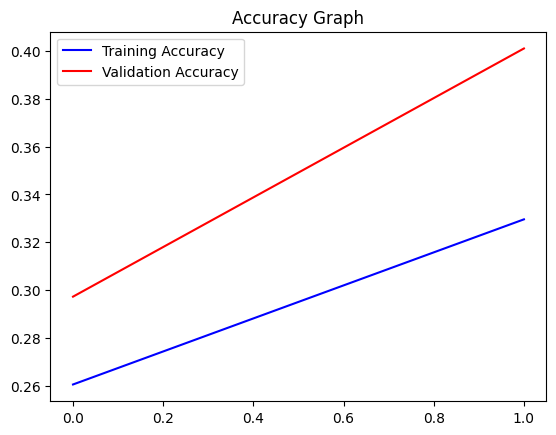

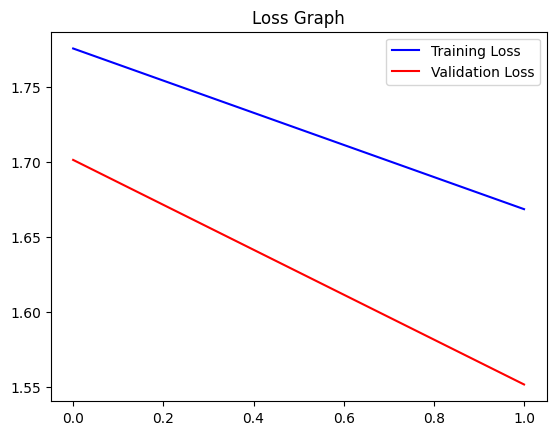

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()

plt.show()


Original Output: happy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Predicted Output: happy


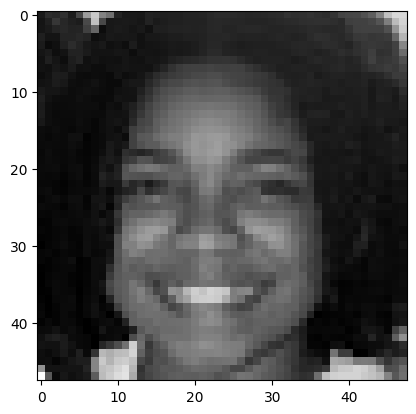

In [36]:
image_index = random.randint(0, len(test))
print("Original Output:", test['label'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray');